# Kaggle

## Human Activity Recogniton with Smartphones
-----
### Description

The Human Activity Recognition database was built from the recordings of 30 study participants performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities performed.

### Activities

Each person performed six activities (WALKING, WALKING_UPSTAIRS,  WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist, more detail follow this [link](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones).

First we should load libraries necessary to work. 

Dependencies:
- Python 3
- numpy 
- pandas 
- sklearn
- jupyter notebook
- matplotlib

In [1]:
import numpy as np
import pandas as pd
import time

Download the database from previous link and add to the folder where you will run this notebook. 

In [2]:
test  = pd.read_csv("./test.csv")
train = pd.read_csv("./train.csv")

In the documentation of the database, it describes a _561-feature_ vector with time and frequency domain variables. The last two colums of database are Subject ID and Activity. There are two approaches I can take for the model classification **user-dependent**, or **user-independent**. User-dependent train and test a model using data collect from one subject only and user-independet apply the model over data from various subjects. Dependent model can achieve good accuracy in classification but lack on generalization over new subjects data. I will train over all data so it will be a **_user-independent_** model. Therefore Subject column will be dropped and Activity column will be our labels for training and testing.

In [3]:
print("Number of features in Train : ", train.shape[1])
print("Number of records  in Train : ",train.shape[0])
print("Number of features in Test  : ",test.shape[1])
print("Number of records  in Test  : ",test.shape[0])

trainData  = train.drop(['subject','Activity'] , axis=1).values
trainLabel = train.Activity.values

testData  = test.drop(['subject','Activity'] , axis=1).values
testLabel = test.Activity.values

print("Train Data shape  : ",trainData.shape)
print("Train Label shape : ",trainLabel.shape)
print("Test Data  shape  : ",testData.shape)
print("Test Label shape  : ",testLabel.shape)

print("Label examples: ")
print(np.unique(trainLabel))

Number of features in Train :  563
Number of records  in Train :  7352
Number of features in Test  :  563
Number of records  in Test  :  2947
Train Data shape  :  (7352, 561)
Train Label shape :  (7352,)
Test Data  shape  :  (2947, 561)
Test Label shape  :  (2947,)
Label examples: 
['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


-----
One problem that appears is the data in Label are strings and should be categorical. I solve that with next lines

-----


In [4]:
from sklearn import preprocessing
from sklearn import utils

ltrain = preprocessing.LabelEncoder()
ltest = preprocessing.LabelEncoder()

trainLabel = ltrain.fit_transform(trainLabel)
testLabel  = ltest.fit_transform(testLabel)

print(np.unique(trainLabel))
print(np.unique(testLabel))
print("Train Label shape : ",trainLabel.shape)
print("Test Label shape  : ",testLabel.shape)
print(utils.multiclass.type_of_target(testLabel))

[0 1 2 3 4 5]
[0 1 2 3 4 5]
Train Label shape :  (7352,)
Test Label shape  :  (2947,)
multiclass


Originally a lot of features can give us a good classififer, but it can ended overfitting our model and not be able to generalize new data. One of the basic apporaches followed is feature reduction and there are a lot of options available, you can follow this link to [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) but there is a lot of material you can search on web.

- SVM: A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.
![Fig 1]( http://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png "Logo Title Text 1")

- RFECV: A recursive feature elimination example with automatic tuning of the number of features selected with cross-validation.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle

In [6]:
t0 = time.clock()
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='accuracy')
# Before training the data it is convenient to shuffle the data in training
np.random.seed(1)
print("Labels before Shuffle",testLabel[0:5])
testData,testLabel = shuffle(testData,testLabel)
trainData,trainLabel = shuffle(trainData,trainLabel)
print("Labels after Shuffle",testLabel[0:5])

Labels before Shuffle [2 2 2 2 2]
Labels after Shuffle [2 0 2 5 4]


Optimal number of features : 373
Processing time sec  3745.5015980626345


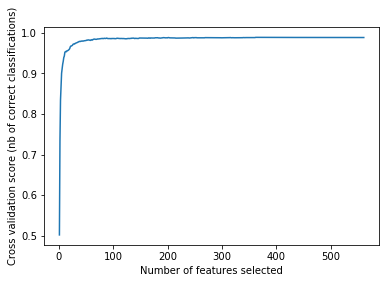

In [7]:
# train and fit data in the model
rfecv.fit(trainData, trainLabel)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Processing time sec ",time.clock() - t0)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

After ~3700 seconds (~one hour in all train data) an SVM model have been trained optimizing the features in the database. Selecting these features can reduce the time of trainig of the model so instead of trainig with **561** features it is necessary only **373**. 

In [8]:
print('Accuracy of the SVM model on test data is ', rfecv.score(testData,testLabel) )
print('Ranking of features starting from the best estimated \n',rfecv.ranking_)
# if we mask the features to get only the best we get this
best_features = []
for ix,val in enumerate(rfecv.support_):
    if val==True:
        best_features.append(testData[:,ix])

Accuracy of the SVM model on test data is  0.964709874449
Ranking of features starting from the best estimated 
 [  1  21   1   1   1  47   1   1   1   1   1   1   1   1   1   1   1 182
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1 133   1   1 144   1   1   1   1   1   1   1
   1   1   1   1   1 108  95   1   1   1   1   1   1   1   1   1   1   1
   1   1   1  23   1  24   1   2  90   1  59  67   1   1  60  39   1   1
   1   1   1   1   1  80 171 157  45 100   1  15   1   1   1   1   1 142
   1   1   1   1   1   1   1   1  42   1   1   1   1   1   1  49   1   1
  82   1   1   1   1   1   1   1   1   1   1  92  52   1   1   1   1   1
  25   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  91   1  76   1   1  71   1   1   1   1   1  93   1   1   1 184 178   1
  34   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1  38   1  65   1   1   1  85   1   1   1   1   1
   1  28   

## Visualize

From previous result, model obtain an accuracy of **96.4%** using **373** features from database. Some previous result to these was Accuracy of _94%_ using _150_ features and _95%_ using _163_ features. Different choose of features will give us different results, so there is the work to be done. Now just a visualization of the correlation between some features, it can be changed inside the iloc functions.

(2947, 373)


C:\Users\bio\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000193AB8DECF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000193AAD4A128>]], dtype=object)

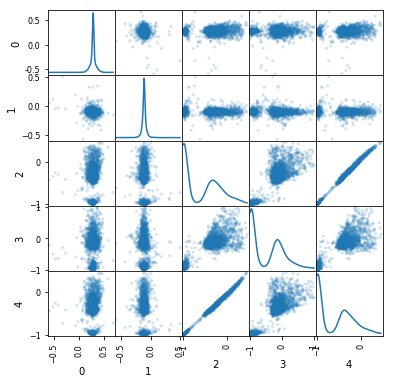

In [10]:
from pandas.tools.plotting import scatter_matrix
visualize = pd.DataFrame(np.asarray(best_features).T)
print(visualize.shape)
scatter_matrix(visualize.iloc[:,0:5], alpha=0.2, figsize=(6, 6), diagonal='kde')

## Conclusion

A classification model based on SVM, applied to statistical and frecuency features from "Human Activity Recognition with Smartphones" database. Accuracy  obtained an acceptable 96% in the test data. Options to improve and change the algoritm could be try different kernels on SVM usig sklearn or different feature extraction methods. Improving algorithms maybe can tell the difference between one subject and another. Also another option could be implement a batch learning process.